IMPORT MODULES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import functions
import scipy.integrate
import scipy.optimize
import scipy.stats as stats
import math

CONSTANTS

In [2]:
global H_0, m_0, c
H_0 = 75 * 10**3 / (3.086*10**22) # s^-1
m_0 = -20.45
c = 299792458 # m/s

Investigate relationship between luminosity distance and redshift

_NOTE: We expect a  roughly linear relationship between distance and redshift, known as Hubble’s Law. However, if we extend the measurement to more distant objects, the relation becomes curved, and strongly dependent on the matter content of the Universe._

Text(0, 0.5, 'Redshift $z$')

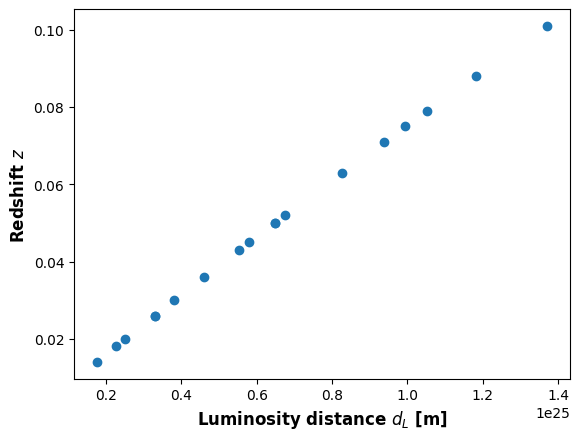

In [3]:
#reads data
name, redshift, eff_peak_mag, mag_err = functions.read_data('sn_data_milestone.txt')

#z < 0.1 data
low_redshift_indices = np.where(redshift<0.102)[0]
comoving_distance = functions.get_comoving_distance_low_z(redshift[low_redshift_indices[0]:low_redshift_indices[-1]+1], H_0)
peak_flux, peak_flux_err = functions.get_flux(eff_peak_mag, mag_err, m_0)
d_L = functions.get_luminosity_distance(redshift[low_redshift_indices[0]:low_redshift_indices[-1]+1], comoving_distance)
plt.scatter(d_L, redshift[low_redshift_indices[0]:low_redshift_indices[-1]+1])
plt.xlabel('Luminosity distance $d_L$ [m]', weight = 'bold', fontsize = 12)
plt.ylabel('Redshift $z$', weight = 'bold', fontsize = 12)

Plotting effective magnitude against luminosity distance and fitting a curve to obtain the peak luminosity.

Text(0, 0.5, 'Effective magnitude $m_{eff}$')

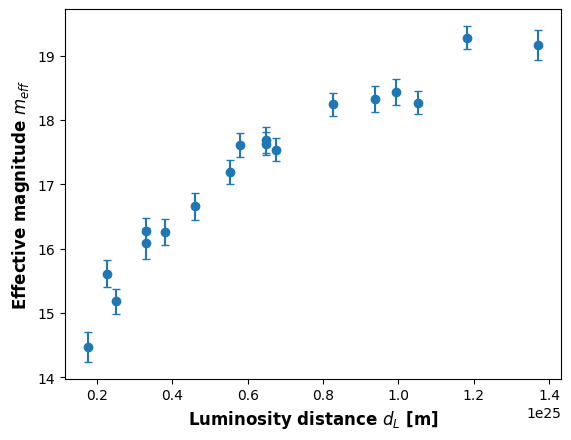

In [4]:
plt.errorbar(d_L, eff_peak_mag[low_redshift_indices[0]:low_redshift_indices[-1]+1], yerr = mag_err[low_redshift_indices[0]:low_redshift_indices[-1]+1], 
             ls='none', marker = 'o', capsize = 3)
plt.xlabel('Luminosity distance $d_L$ [m]', weight = 'bold', fontsize = 12)
plt.ylabel('Effective magnitude $m_{eff}$', weight = 'bold', fontsize = 12)

DoF = 17
Optimised parameters =  [3.26144341e+39] 

Covariance matrix = 
 [[1.94719522e+76]]


c:\Users\bradl\.vscode\computing_project\Supernova_Cosmology\functions.py:105: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(xval,
c:\Users\bradl\.vscode\computing_project\Supernova_Cosmology\functions.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(xval,


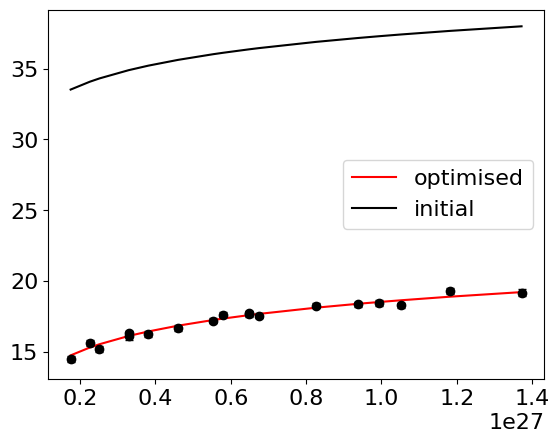

chi^2_min = 21.455532501736734
reduced chi^2 = 1.2620901471609844
$P(chi^2_min, DoF)$ = 0.206574238445178


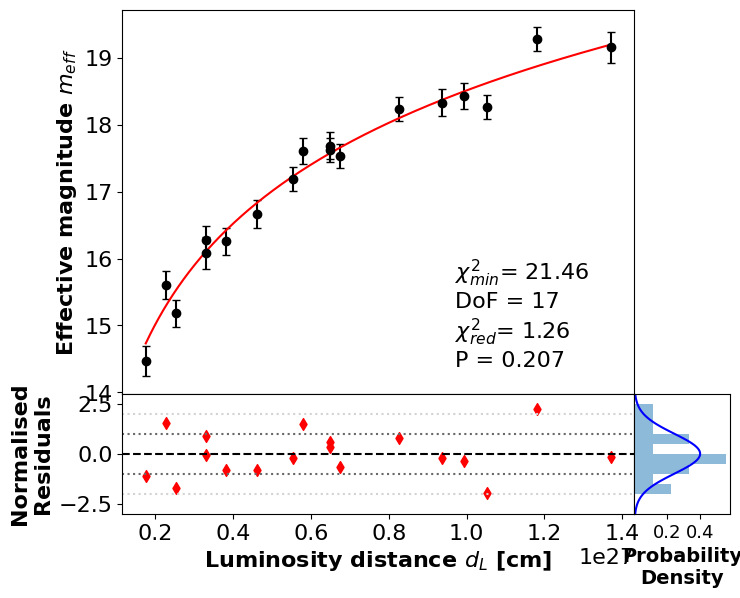

optimised parameter[0] = 3.261443407267811e+39 +/- 1.3954193699027837e+38
3.2614434072678105e+32
1.3954193699027836e+31


In [5]:
#chi squared fitting

xval = d_L*100 # cm
yval = eff_peak_mag[low_redshift_indices[0]:low_redshift_indices[-1]+1]
yerr = mag_err[low_redshift_indices[0]:low_redshift_indices[-1]+1]

def model_funct(x, *vals):
    return -2.5*np.log10(vals[0]/(4*np.pi*x**2)) + m_0

initial = np.array([1.0*10**32]) # Initial guess for fit parameters

plt.rcParams.update({'font.size': 16})

parameters = functions.automated_curve_fitting(xval, yval, yerr, model_funct, initial, 
                                               xlabel = 'Luminosity distance $d_L$ [cm]', 
                                               ylabel = 'Effective magnitude $m_{eff}$') #optimised parameters given in erg/s/Ang
L_peak = parameters[0][0]*10**-7 #W/Ang
L_peak_err = parameters[1][0]*10**-7 #W/Ang

print(L_peak)
print(L_peak_err)

DoF = 17
Optimised parameters =  [19263.73556048] 

Covariance matrix = 
 [[679312.11508908]]


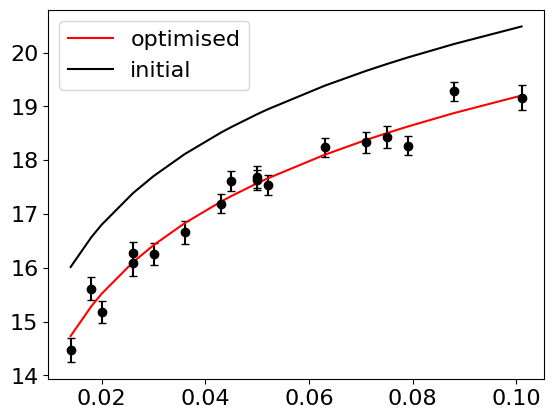

chi^2_min = 21.45553250173687
reduced chi^2 = 1.2620901471609922
$P(chi^2_min, DoF)$ = 0.2065742384451721


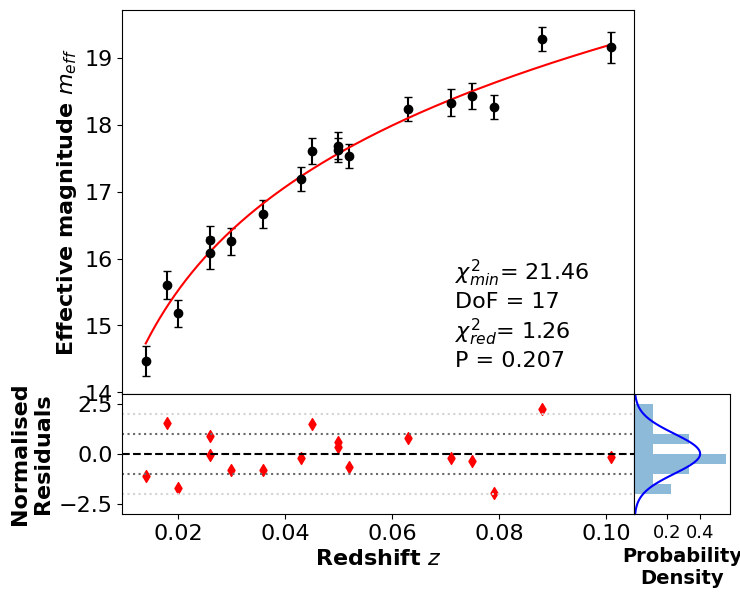

optimised parameter[0] = 19263.735560482088 +/- 824.2039280961209
3.2614432387867166e+32
1.3954169585804234e+31


In [6]:
#chi squared fitting - fitting L_peak*H_0**2

xval = redshift[low_redshift_indices[0]:low_redshift_indices[-1]+1]
yval = eff_peak_mag[low_redshift_indices[0]:low_redshift_indices[-1]+1]
yerr = mag_err[low_redshift_indices[0]:low_redshift_indices[-1]+1]

def model_funct(x, *vals):
    return -2.5*np.log10(np.array((vals[0]/(4*np.pi*(1+x)**2*(c*10**2)**2*x**2)), dtype = 'float')) + m_0

initial = np.array([1.0*10**39*H_0**2]) # Initial guess for fit parameters

plt.rcParams.update({'font.size': 16})

parameters = functions.automated_curve_fitting(xval, yval, yerr, model_funct, initial, 
                                               xlabel = 'Redshift $z$', 
                                               ylabel = 'Effective magnitude $m_{eff}$') #optimised parameters given in erg/s/Ang
L_peak = parameters[0][0]*10**-7/H_0**2 #W/Ang
L_peak_err = parameters[1][0]*10**-7/H_0**2 #W/Ang

print(L_peak) #Watts/Ang
print(L_peak_err) #Watts/Ang

Calculate Ω_Λ,0

81.33098369373201


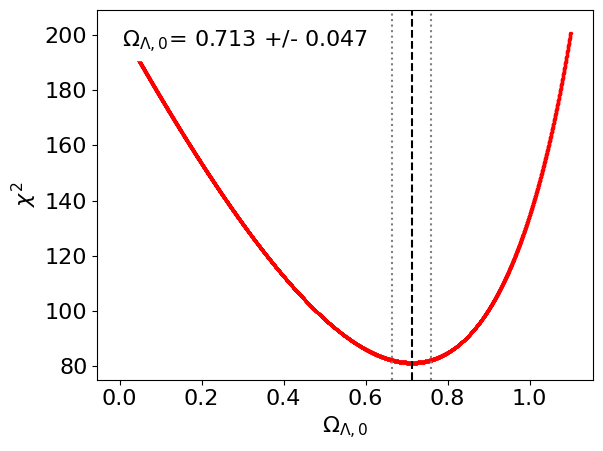

In [7]:
#extracting the high redshift data
high_redshift_indices = np.where(redshift > 0.102)[0]
#setting some parameters for the resulting plots.
plt.rcParams.update({'font.size': 16})

#determining omega_lambda,0 and its error by finding the chi-squaerd value for a range of trial values of omega_lambda,0,
#plotting these, and then taking the best fit value for omega_lambda,0 as the trial value that corresponds to the minimum
#chi-sq value. The error is found by calculating how much the trial values vary within delta chi-sq = +/- 1.
omega_lambda, omega_lambda_err = functions.find_omega_lambda_and_error(redshift[high_redshift_indices[0]:high_redshift_indices[-1]+1], eff_peak_mag[high_redshift_indices[0]:high_redshift_indices[-1]+1], 
                                                             mag_err[high_redshift_indices[0]:high_redshift_indices[-1]+1], L_peak, H_0, m_0)


PLOTTING OBSERVED AND PREDICTED SUPERNOVA MAGNITUDES AGAINST REDSHIFT

(-3.0, 3.0)

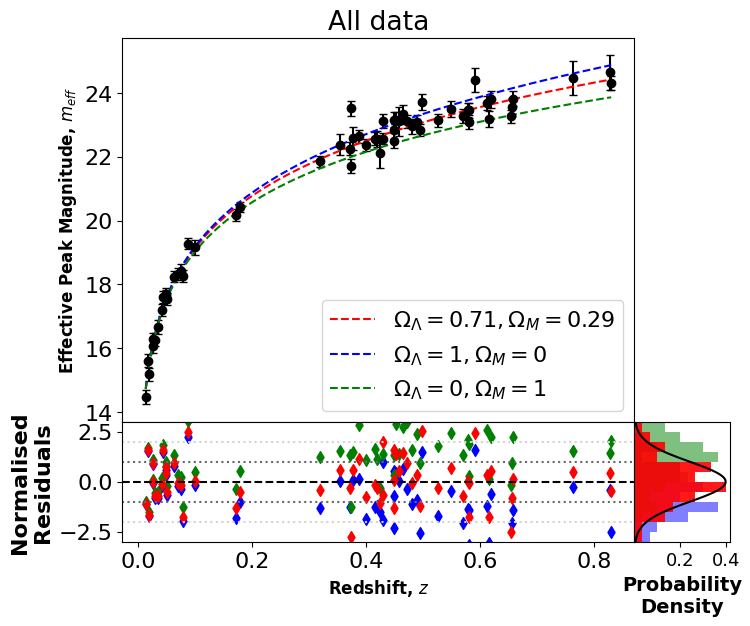

In [8]:
#The aim of this code is to produce a plot with residuals which shows how well 3 different models fit the data.

#the model function we are fitting the data to.
def model_funct(redshift, model_params):
    try:
        flux_predicted = L_peak/(4*np.pi*(1+redshift)**2*(functions.integrate_array(functions.comoving_distance_integrand, np.zeros(len(redshift.tolist())), redshift, args=(H_0, model_params, 1-model_params)))**2) #W/m^2/Ang
    except:
        flux_predicted = L_peak/(4*np.pi*(1+redshift)**2*(functions.integrate_array(functions.comoving_distance_integrand, [0], [redshift], args=(H_0, model_params, 1-model_params)))**2) #W/m^2/Ang
    flux_predicted = flux_predicted * 10**7 * 10**-4 #erg/s/cm^2/Angstrom
    mag_predicted = m_0 - 2.5*np.log10(flux_predicted) 
    return mag_predicted

#top plot - plotting observed data with three lines corresponding to the three different combinations of the density parameters in the model function.
plt.figure(1)
plt.figure(1).add_axes((0,0,0.8,0.8))
plt.errorbar(redshift, eff_peak_mag, yerr = mag_err, color = 'black', capsize = 3, marker='o', linestyle='None')
plt.plot(np.linspace(np.min(redshift), np.max(redshift), 1000), functions.mag_model(np.linspace(np.min(redshift), np.max(redshift), 1000), L_peak, H_0, m_0, omega_lambda, 1-omega_lambda), label = f'$Ω_Λ = {np.round(omega_lambda, 2)}, Ω_M = {np.round(1-omega_lambda, 2)}$', color = 'red', linestyle = '--')
plt.plot(np.linspace(np.min(redshift), np.max(redshift), 1000), functions.mag_model(np.linspace(np.min(redshift), np.max(redshift), 1000), L_peak, H_0, m_0, 1, 0), label = '$Ω_Λ = 1, Ω_M = 0$', color = 'blue', linestyle = '--')
plt.plot(np.linspace(np.min(redshift), np.max(redshift), 1000), functions.mag_model(np.linspace(np.min(redshift), np.max(redshift), 1000), L_peak, H_0, m_0, 0, 1), label = '$Ω_Λ = 0, Ω_M = 1$', color = 'green', linestyle = '--')
plt.ylabel('Effective Peak Magnitude, $m_{eff}$', weight = 'bold', fontsize = 12)
plt.legend()
plt.title('All data')

#bottom left plot - plotting residuals for three different model functions.
plt.figure(1).add_axes((0,-0.25,0.8,0.25))
colours = ['blue', 'green', 'red']
omega_lambdas = [1, 0, omega_lambda]
plt.ylabel("""Normalised
Residuals""", weight = 'bold')
plt.ylim(-3, 3)
plt.axhline(y = 0, linestyle = '--', color = 'black')
plt.axhline(y = 1, linestyle = ':', color = 'dimgrey'); plt.axhline(y = -1, linestyle = ':', color = 'dimgrey')
plt.axhline(y = 2, linestyle = ':', color = 'lightgrey'); plt.axhline(y = -2, linestyle = ':', color = 'lightgrey')
plt.xlabel('Redshift, $z$', weight = 'bold', fontsize = 12)
for i in range(0, len(colours)):
        norm_residuals = functions.get_norm_residuals([omega_lambdas[i]], model_funct, redshift, eff_peak_mag, mag_err)
        plt.scatter(redshift, norm_residuals, color=colours[i], marker = 'd')

#bottom right plot - plotting normalised residual distribution histogram for each of the three cases, with a Gaussian centred on 0 superimposed on top.
plt.figure(1).add_axes((0.8,-0.25,0.15,0.25))
plt.xticks([0.2,0.4], fontsize = 13)
mu = 0; variance = 1
sigma = math.sqrt(variance)    
y = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(stats.norm.pdf(y, mu, sigma), y, color = 'black')
plt.xlabel("""Probability
Density""", fontsize = 14, weight = 'bold')
plt.gca().set_yticks([])
plt.gca().invert_yaxis()
for i in range(0, len(colours)):
        norm_residuals = functions.get_norm_residuals([omega_lambdas[i]], model_funct, redshift, eff_peak_mag, mag_err)
        plt.hist(norm_residuals, bins=np.arange(-10, 10, 0.5), alpha = [0.5, 0.5, 0.9][i], density = True, orientation = 'horizontal', color = colours[i])
plt.ylim(-3, 3)

EXTENSIONS TO MILESTONE

DoF = 58
Optimised parameters =  [1.45513215 0.92245284] 

Covariance matrix = 
 [[0.24303994 0.20353809]
 [0.20353809 0.17812485]]


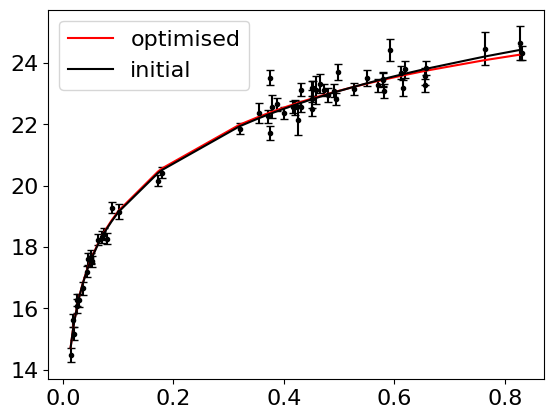

chi^2_min = 101.59582836696615
reduced chi^2 = 1.7516522132235541
$P(chi^2_min, DoF)$ = 0.0003521023977908351


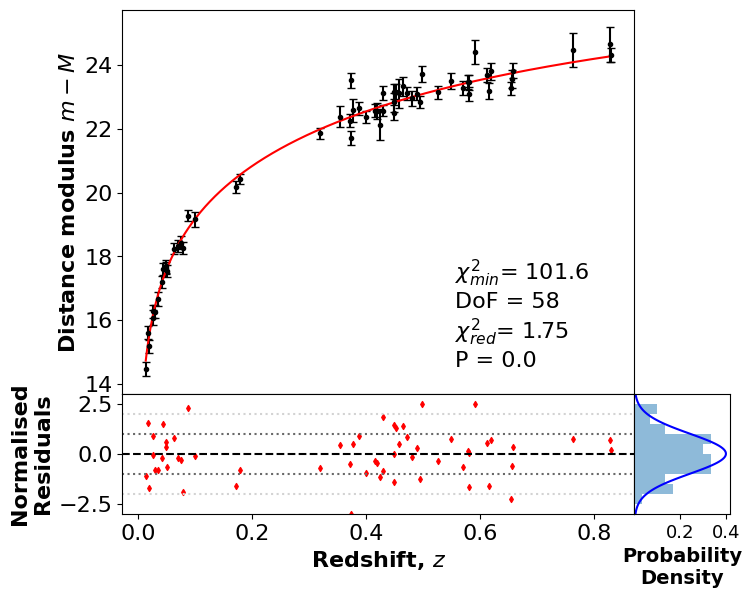

optimised parameter[0] = 1.4551321548681375 +/- 0.49299081542828044
optimised parameter[1] = 0.9224528388095791 +/- 0.4220483951737676
omega_TOT = 2.3775849936777167 +/- 0.6489721041503969


In [10]:
#chi squared fitting

#defining x and y values and the y errors for the chi squared fitting.
xval = redshift
yval = eff_peak_mag
yerr = mag_err

#setting some parameters for the resulting plots.
plt.rcParams.update({'font.size': 16, 'lines.markersize': 3})

#the model function that we're fitting to the dataset.
def model_funct(xs, *vals):
    flux_predicted = L_peak/(4*np.pi*(1+xs)**2*functions.get_transverse_comoving_distance(xs, H_0, vals[0], vals[1])**2) #W/m^2/Ang
    flux_predicted = flux_predicted * 10**7 * 10**-4 #erg/s/cm^2/Angstrom
    mag_predicted = m_0 - 2.5*np.log10(flux_predicted) 
    return mag_predicted

initial = np.array([0.72, 0.28]) # Initial guess for fit parameters

#runs the automated chi squared fitting of the x and y data to the model function above, returning chi-squared statistics and the best fit parameters and their errors.
parameters = functions.automated_curve_fitting(xval, yval, yerr, model_funct, initial, 
                                                xlabel = 'Redshift, $z$', 
                                                ylabel = 'Distance modulus $m - M$') #optimised parameters given in erg/s/Ang
#prints the total density parameter to check how close it is to 1 (flat universe).
print('omega_TOT = {} +/- {}'.format(np.sum(parameters[0]), np.sqrt(np.sum(parameters[1]**2))))